In [1]:
import tensorflow as tf

2023-09-22 11:53:06.983715: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 11:53:12.075033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 11:53:16.804527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion, zoom
from scipy.stats import wilcoxon

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

from IPython import display
import datetime
import cv2

from data_loader import load_data
from sr_utility import space_to_depth, depth_to_space
import data_utils

from IPython.display import clear_output

import model

In [4]:
subjects = [ f.name for f in os.scandir('../HCPData') if f.is_dir() and f.name != 'Input' and f.name != '.ipynb_checkpoints' and f.name != 'TrainingData' and f.name != 'TestOutput']

# subjects = ['390645', '120111']

subjects = ['390645', '545345', '106016', '120111', '101915', '351938', '705341', '951457']

ds = 2

e_or_o = 1

LAMBDA = 1000

p_size_i = 5
p_size_o = 3

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341', '951457']


In [14]:
subjects_lr, subjects_t1, subjects_hr, subjects_masks, [transform_lr, transform_hr] = load_data("../HCPData", subjects, pads = [(8+16, 7+16), (9+8, 9+8), (8+16, 7+16), (0,0)])

Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341
Loading Subject 951457


In [9]:
# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
# generator = model.simple_generator(6,6,2*p_size_i+e_or_o, f_num=50, ds=ds)
# generator = model.simple_multimodal_generator(6,64,6,2*p_size_i+e_or_o, f_num=50)
# generator = model.simple_multimodal_generator_2(6,64,6,2*p_size_i+e_or_o, f_num=100)

# generator = model.simple_generator_mmodal(6,6,2*p_size_i+e_or_o, f_num=50, ds=ds)
generator = model.simple_generator_mmodal_2(6,6,2*p_size_i+e_or_o, f_num=50, ds=ds)
# discriminator = model.simple_discriminator(6,2*(2*p_size_o+e_or_o), f_num=50, layer_num=1)

discriminator = model.simple_discriminator(6,(2*p_size_o+e_or_o), f_num=50, layer_num=1)

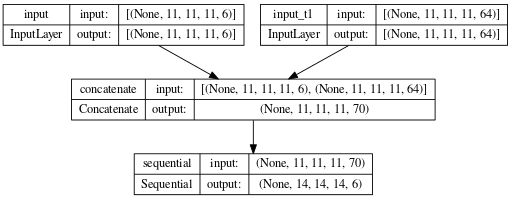

In [7]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

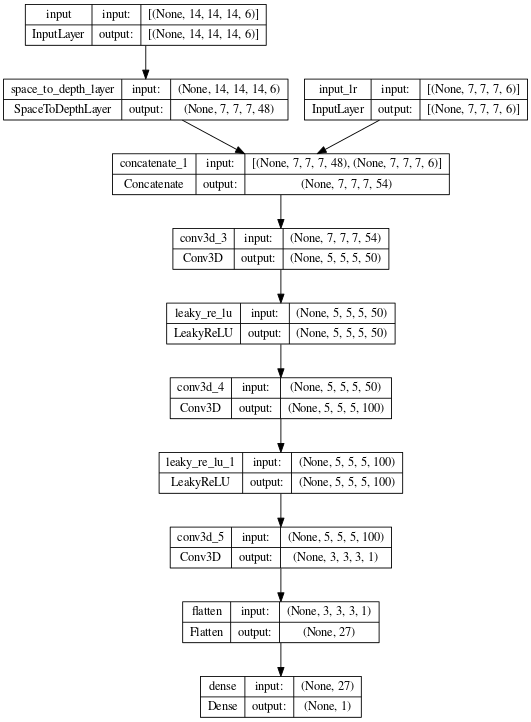

In [8]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [9]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # real_loss = tf.reduce_mean(
  #     tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_real_output), 
  #                                             logits=disc_real_output))

  # generated_loss = tf.reduce_mean(
  #     tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(disc_generated_output), 
  #                                             logits=disc_generated_output))

  real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_real_output), 
                                                                     logits=disc_real_output))

  generated_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(disc_generated_output), 
                                                                          logits=disc_generated_output))

  # print(generated_loss)
    
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  # gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # gan_loss = tf.reduce_mean(loss_object(tf.ones_like(disc_generated_output), disc_generated_output))

  gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_generated_output,
                                                     labels=tf.ones_like(disc_generated_output)))

  # Mean squared error
  # l2_loss = tf.reduce_mean(tf.square(target - gen_output), axis=[1,2,3,4])
  l2_loss = tf.reduce_mean(tf.square(target - gen_output))

  # l2_loss = tf.keras.losses.MeanSquaredError()(target, gen_output)
    
  total_gen_loss = l2_loss + gan_loss / LAMBDA

  # total_gen_loss = l2_loss

  return total_gen_loss, gan_loss, l2_loss

In [8]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=50,
#     decay_rate=0.1
# )

class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  # def __call__(self, step):
  #     return self.initial_learning_rate * tf.math.pow(0.1, tf.cast(step//100, tf.float32))

  def __call__(self, step):
      return (self.initial_learning_rate * tf.math.pow(0.1, tf.cast(step//50, tf.float32)))

# _lr = LRSchedule(2e-3) # LRSchedule(1e-3)

# _lr = LRSchedule(1e-3) # LRSchedule(1e-3)

_lr = 1e-3

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=_lr)#, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=_lr)#, beta_1=0.5)

2023-09-22 12:01:31.292233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 12:01:33.715225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 12:01:33.715566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)

In [12]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = './logs/ganlogslambda{}_shuf_t1/'.format(LAMBDA) + current_time + '/train'
# log_dir = './logs/lambda{}_no_t1/'.format(LAMBDA) + current_time + '/train'

# log_dir = './logs/espcn_baseline_t2_start/' + current_time + '/train'
log_dir = './logs/espcn_GAN_t1/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [13]:
@tf.function
def train_step(lr_patch, hr_patch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    lr_patch_dti = tf.slice(lr_patch[0], [0, 2, 2, 2, 0], [-1, 7, 7, 7, -1])
      
    generated_images = generator(lr_patch, training=True)
    
    real_output = discriminator([hr_patch, lr_patch_dti], training=True)
    fake_output = discriminator([generated_images, lr_patch_dti], training=True)
    # real_output = discriminator(hr_patch, training=True)
    # fake_output = discriminator(generated_images, training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, hr_patch)
    disc_loss = discriminator_loss(real_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  return tf.reduce_mean(gen_total_loss), tf.reduce_mean(gen_gan_loss), tf.reduce_mean(gen_l1_loss), tf.reduce_mean(disc_loss)

@tf.function
def val_step(lr_patch, hr_patch):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    lr_patch_dti = tf.slice(lr_patch[0], [0, 2, 2, 2, 0], [-1, 7, 7, 7, -1])
      
    generated_images = generator(lr_patch, training=False)
    
    real_output = discriminator([hr_patch, lr_patch_dti], training=False)
    fake_output = discriminator([generated_images, lr_patch_dti], training=False)

    # real_output = discriminator(hr_patch, training=False)
    # fake_output = discriminator(generated_images, training=False)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, hr_patch)
    disc_loss = discriminator_loss(real_output, fake_output)

    return tf.reduce_mean(gen_total_loss), tf.reduce_mean(gen_gan_loss), tf.reduce_mean(gen_l1_loss), tf.reduce_mean(disc_loss)

In [14]:
# batch_size = 12

# val_size = batch_size // 2 # Roughly 20%


# def train(data, epochs, c_epoch=0):

#   gen_train_mode = False

#   best_cost = np.Inf

#   # generator.compile(optimizer=generator_optimizer,
#   #                   loss=tf.keras.losses.MeanSquaredError(),
#   #                   metrics=['accuracy'])
    
#   for epoch in range(c_epoch, epochs):

#     metrics = np.zeros(4)
      
#     start = time.time()

#     print("Epoch: {}".format(epoch+1))

#     print("Learning rate:", generator_optimizer.learning_rate.numpy())

#     randsels = np.random.choice(data[0].shape[0], batch_size)

#     train_sels = randsels[:batch_size-val_size]

#     val_sels = randsels[batch_size-val_size:]

#     lr_patches = []
#     t1_patches = []
#     hr_patches = []

#     for prog, index in enumerate(tqdm(train_sels)):

#             (s, i, j, k) = np.copy(data[0][index])

#             lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

#             lr_patch =  np.copy(data[1][s][::ds,::ds,::ds,:])[
#                                         i - p_size_i : i + p_size_i + 1,
#                                         j - p_size_i : j + p_size_i + 1,
#                                         k - p_size_i : k + p_size_i + 1,:] #* \
#                         # np.copy(data[3][s][::ds,::ds,::ds])[
#                         #                 (i - p_size_i) : (i + p_size_i + 1),
#                         #                 (j - p_size_i) : (j + p_size_i + 1),
#                         #                 (k - p_size_i) : (k + p_size_i + 1), None]

#             t1_patch =  np.copy(data[4][s])[
#                                     ds*(i - p_size_i) : ds*(i + p_size_i + 1),
#                                     ds*(j - p_size_i) : ds*(j + p_size_i + 1),
#                                     ds*(k - p_size_i) : ds*(k + p_size_i + 1),:] #* \
#                         # np.copy(data[3][s])[
#                         #             ds*(i - p_size_i) : ds*(i + p_size_i + 1),
#                         #             ds*(j - p_size_i) : ds*(j + p_size_i + 1),
#                         #             ds*(k - p_size_i) : ds*(k + p_size_i + 1), None]

#             # lr_patch_samp[...,:6] = lr_patch
#             # lr_patch_samp[...,6:] = t1_patch

#             # lr_patch = lr_patch_samp
            
#             hr_patch = np.copy(data[2][s])[
#                                     ds*(i - p_size_o) : ds*(i + p_size_o + 1),
#                                     ds*(j - p_size_o) : ds*(j + p_size_o + 1),
#                                     ds*(k - p_size_o) : ds*(k + p_size_o + 1), :] * \
#                        np.copy(data[3][s])[
#                                     ds*(i - p_size_o) : ds*(i + p_size_o + 1),
#                                     ds*(j - p_size_o) : ds*(j + p_size_o + 1),
#                                     ds*(k - p_size_o) : ds*(k + p_size_o + 1), None]

#             # for ch in range(6):
#             #     lr_patch[...,ch] = (lr_patch[...,ch] - np.mean(lr_patch[...,ch])) / np.std(lr_patch[...,ch])
#             #     hr_patch[...,ch] = (hr_patch[...,ch] - np.mean(hr_patch[...,ch])) / np.std(hr_patch[...,ch])

#             # hr_patch = (hr_patch - np.mean(hr_patch)) / np.std(hr_patch)

#             lr_patches.append(lr_patch)
#             t1_patches.append(space_to_depth(t1_patch,ds))
#             hr_patches.append((hr_patch))


#     lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
#     t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
#     hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

#     # print(tf.shape(hr_patches))

#     # t_loss = train_step([lr_patches, t1_patches], hr_patches)
#     t_loss = train_step(lr_patches, hr_patches)

#     # history = generator.fit(
#     #     x=lr_patches,
#     #     y=hr_patches
#     # )

#     # print('Training L2 Loss is {}'.format(history))
      
#     print('Training L2 Loss is {}'.format(t_loss[2]))

#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', t_loss[0], step=epoch)
#         tf.summary.scalar('gen_gan_loss', t_loss[1], step=epoch)
#         tf.summary.scalar('gen_l1_loss', t_loss[2], step=epoch)
#         tf.summary.scalar('disc_loss', t_loss[3], step=epoch)
    
#     lr_patches = []
#     t1_patches = []
#     hr_patches = []

#     for prog, index in enumerate(tqdm(val_sels)):

#             (s, i, j, k) = np.copy(data[0][index])

#             lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

#             lr_patch =  np.copy(data[1][s][::2,::2,::2,:6])[
#                                         (i - p_size_i) : (i + p_size_i + 1),
#                                         (j - p_size_i) : (j + p_size_i + 1),
#                                         (k - p_size_i) : (k + p_size_i + 1),:] #* \
#                         # np.copy(data[3][s][::2,::2,::2])[
#                         #                 (i - p_size_i) : (i + p_size_i + 1),
#                         #                 (j - p_size_i) : (j + p_size_i + 1),
#                         #                 (k - p_size_i) : (k + p_size_i + 1), None]

#             # lr_patch = (lr_patch - np.mean(lr_patch)) / np.std(lr_patch)

#             t1_patch =  np.copy(data[4][s])[
#                                     ds*(i - p_size_i) : ds*(i + p_size_i + 1),
#                                     ds*(j - p_size_i) : ds*(j + p_size_i + 1),
#                                     ds*(k - p_size_i) : ds*(k + p_size_i + 1),:] #* \
#                         # np.copy(data[3][s])[
#                         #             ds*(i - p_size_i) : ds*(i + p_size_i + 1),
#                         #             ds*(j - p_size_i) : ds*(j + p_size_i + 1),
#                         #             ds*(k - p_size_i) : ds*(k + p_size_i + 1), None]

#             # t1_patch = (t1_patch - np.mean(t1_patch)) / np.std(t1_patch)

#             # lr_patch_samp[...,:6] = lr_patch
#             # lr_patch_samp[...,6:] = t1_patch

#             # lr_patch = lr_patch_samp
            
#             hr_patch = np.copy(data[2][s])[
#                                     ds*(i - p_size_o) : ds*(i + p_size_o + 1),
#                                     ds*(j - p_size_o) : ds*(j + p_size_o + 1),
#                                     ds*(k - p_size_o) : ds*(k + p_size_o + 1), :] #* \
#                        # np.copy(data[3][s])[
#                        #              ds*(i - p_size_o) : ds*(i + p_size_o + 1),
#                        #              ds*(j - p_size_o) : ds*(j + p_size_o + 1),
#                        #              ds*(k - p_size_o) : ds*(k + p_size_o + 1), None]

#             # for ch in range(6):
#             #     lr_patch[...,ch] = (lr_patch[...,ch] - np.mean(lr_patch[...,ch])) / np.std(lr_patch[...,ch])
#             #     hr_patch[...,ch] = (hr_patch[...,ch] - np.mean(hr_patch[...,ch])) / np.std(hr_patch[...,ch])
        
#             # hr_patch = (hr_patch - np.mean(hr_patch)) / np.std(hr_patch)

#             lr_patches.append(lr_patch)
#             t1_patches.append(space_to_depth(t1_patch,ds))
#             hr_patches.append((hr_patch))
            
#             continue

#     lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
#     t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
#     hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

#     # output = model_unet([lr_patches, t1_patches], training=False)

#     # v_loss = val_step([lr_patches, t1_patches], hr_patches)
#     v_loss = val_step(lr_patches, hr_patches)

#     # if (epoch + 1) % 5 == 0:

#     #     recon_patches = generator(lr_patches, training=False)

#     #     print(tf.shape(recon_patches))
        
#     #     plt.figure()
#     #     plt.imshow(recon_patches[0,:,:,7,0])
#     #     plt.figure()
#     #     plt.imshow(recon_patches[1,:,:,7,0])
#     #     plt.figure()
#     #     plt.imshow(recon_patches[2,:,:,7,0])
      
#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss_valid', v_loss[0], step=epoch)
#         tf.summary.scalar('gen_gan_loss_valid', v_loss[1], step=epoch)
#         tf.summary.scalar('gen_l1_loss_valid', v_loss[2], step=epoch)
#         tf.summary.scalar('disc_loss_valid', v_loss[3], step=epoch)
      
#     # Save the best validation score
#     if v_loss[2] < best_cost:
#         # checkpoint.save(file_prefix = checkpoint_prefix)
#         manager.save()
#         best_cost = v_loss[2]

#     if (epoch + 1) % 5 == 0:

#         print("Saving Sample Image")
        
#         lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

#         lr_patch = np.copy(data[1][5][::ds,::ds,::ds,:6])[
#                                         (100//ds - p_size_i) : (100//ds + p_size_i + 1),
#                                         (80//ds - p_size_i) : (80//ds + p_size_i + 1),
#                                         (60//ds - p_size_i) : (60//ds + p_size_i + 1),:] #* \
#                     # np.copy(data[3][5][::ds,::ds,::ds])[
#                     #                     (25 - p_size_i) : (25 + p_size_i + 1),
#                     #                     (20 - p_size_i) : (20 + p_size_i + 1),
#                     #                     (15 - p_size_i) : (15 + p_size_i + 1), None]

#         # for ch in range(6):
#         #     lr_patch[...,ch] = (lr_patch[...,ch] - np.mean(lr_patch[...,ch])) / np.std(lr_patch[...,ch])
                
#         # hr_patch = np.copy(data[2][5])[
#         #                             2*(50 - p_size_o) : 2*(50 + p_size_o + 1),
#         #                             2*(40 - p_size_o) : 2*(40 + p_size_o + 1),
#         #                             2*(30 - p_size_o) : 2*(30 + p_size_o + 1), :] * \
#         #            np.copy(data[3][5])[
#         #                             2*(50 - p_size_o) : 2*(50 + p_size_o + 1),
#         #                             2*(40 - p_size_o) : 2*(40 + p_size_o + 1),
#         #                             2*(30 - p_size_o) : 2*(30 + p_size_o + 1), None]

#         # hr_patch_shuf = space_to_depth(hr_patch, 2)

#         # t1_patch = np.copy(data[4][5])[
#         #                                 (100 - 2 * p_size_i) : (100 + 2 *  p_size_i + 2),
#         #                                 (80 - 2 * p_size_i) : (80 + 2 * p_size_i + 2),
#         #                                 (60 - 2 * p_size_i) : (60 + 2 * p_size_i + 2),:] * \
#         #             np.copy(data[3][5])[
#         #                                 (100 - 2 * p_size_i) : (100 + 2 * p_size_i + 2),
#         #                                 (80 - 2 * p_size_i) : (80 + 2 * p_size_i + 2),
#         #                                 (60 - 2 * p_size_i) : (60 + 2 * p_size_i + 2), None]
        
#         # lr_patch_samp[...,:6] = lr_patch
#         # lr_patch_samp[...,6:] = t1_patch

#         # lr_patch = lr_patch_samp

#         img = generator(lr_patch[None,...], training=False)[0,...]

#         # img = generator([lr_patch[None,...], space_to_depth(t1_patch)[None,...]], training=False)[0,...]
        
#         # img = depth_to_space(img, 2)
        
#         with summary_writer.as_default():
#             tf.summary.image("Training data", [img[:,:,7,0,None], img[:,:,7,1,None],
#                                                img[:,:,7,2,None], img[:,:,7,3,None],
#                                                img[:,:,7,4,None], img[:,:,7,5,None]], max_outputs=6, step=epoch)

      


#     print('Validation L2 Loss is {}'.format(v_loss[2]))
      
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#     if (epoch + 1) % 10 == 0:
#         clear_output(wait=True)


In [15]:
batch_size = 12

val_size = 6

train_size = 6

def train(data, epochs, c_epoch=0):

  gen_train_mode = False

  best_cost = np.Inf

  n_train_batches = (8000*8)//batch_size
    
  for epoch in range(c_epoch, epochs):

    metrics = np.zeros(4)
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())

    randsels = np.random.choice(data[0].shape[0], data[0].shape[0])

    randsels_train = randsels[:data[0].shape[0]//2]

    randsels_valid = randsels[data[0].shape[0]//2:]

    for _iter in tqdm(range(n_train_batches)):

        train_sels = randsels_train[_iter*train_size:(_iter+1)*train_size]

        # print(train_sels)
    
        val_sels = randsels_valid[_iter*val_size:(_iter+1)*val_size]
    
        lr_patches = []
        t1_patches = []
        hr_patches = []

        for prog, index in enumerate((train_sels)):
    
                (s, i, j, k) = data[0][index]
    
                # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))
    
                lr_patch = (data[1][s][::ds,::ds,::ds,:])[
                                            i - p_size_i : i + p_size_i + 1,
                                            j - p_size_i : j + p_size_i + 1,
                                            k - p_size_i : k + p_size_i + 1,:]
                
                # lr_patch[lr_patch<-3] = -3
                # lr_patch[lr_patch>3] = 3
    
                t1_patch = (data[4][s])[
                                        ds*(i - p_size_i - 1) : ds*(i + p_size_i),
                                        ds*(j - p_size_i - 1) : ds*(j + p_size_i),
                                        ds*(k - p_size_i - 1) : ds*(k + p_size_i),:]
                
                # t1_patch[t1_patch<-3] = -3
                # t1_patch[t1_patch>3] = 3
                
                hr_patch = (data[2][s])[
                                        ds*(i - p_size_o) : ds*(i + p_size_o + 1),
                                        ds*(j - p_size_o) : ds*(j + p_size_o + 1),
                                        ds*(k - p_size_o) : ds*(k + p_size_o + 1), :]
                
                # hr_patch[hr_patch<-3] = -3
                # hr_patch[hr_patch>3] = 3
    
                lr_patches.append(lr_patch)
                t1_patches.append(space_to_depth(t1_patch,ds))
                hr_patches.append((hr_patch))
    
    
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
          
        # t_loss = train_step(lr_patches, hr_patches)

        t_loss = train_step([lr_patches, t1_patches], hr_patches)
        
        # print('Training L2 Loss is {}'.format(t_loss[2]))

        if (epoch>3 and t_loss[2]) > 1000: #Outlier, find out the reason
            
            return lr_patches, t1_patches, hr_patches, True

    
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', t_loss[0], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_gan_loss', t_loss[1], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_l1_loss', t_loss[2], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('disc_loss', t_loss[3], step=epoch*n_train_batches+_iter)
        
        lr_patches = []
        t1_patches = []
        hr_patches = []
    
        for prog, index in enumerate((val_sels)):
    
                (s, i, j, k) = np.copy(data[0][index])
    
                # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))
    
                lr_patch = (data[1][s][::2,::2,::2,:6])[
                                            (i - p_size_i) : (i + p_size_i + 1),
                                            (j - p_size_i) : (j + p_size_i + 1),
                                            (k - p_size_i) : (k + p_size_i + 1),:]
    
                t1_patch = (data[4][s])[
                                        ds*(i - p_size_i - 1) : ds*(i + p_size_i),
                                        ds*(j - p_size_i - 1) : ds*(j + p_size_i),
                                        ds*(k - p_size_i - 1) : ds*(k + p_size_i),:]
                
                hr_patch = (data[2][s])[
                                        ds*(i - p_size_o) : ds*(i + p_size_o + 1),
                                        ds*(j - p_size_o) : ds*(j + p_size_o + 1),
                                        ds*(k - p_size_o) : ds*(k + p_size_o + 1), :]
    
                lr_patches.append(lr_patch)
                t1_patches.append(space_to_depth(t1_patch,ds))
                hr_patches.append((hr_patch))
                
                continue
    
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        t1_patches = tf.convert_to_tensor(np.array(t1_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
        
        # v_loss = val_step(lr_patches, hr_patches)

        v_loss = val_step([lr_patches, t1_patches], hr_patches)
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss_valid', v_loss[0], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_gan_loss_valid', v_loss[1], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('gen_l1_loss_valid', v_loss[2], step=epoch*n_train_batches+_iter)
            tf.summary.scalar('disc_loss_valid', v_loss[3], step=epoch*n_train_batches+_iter)

        # if v_loss[2] < best_val_cost:
        #     best_val_cost = v_loss[2]
      
        # Save the best validation score from epoch 2 onwards
        if (epoch+1) > 1 and v_loss[2] < best_cost:
            manager.save()
            best_cost = v_loss[2]

    # if (epoch + 1) % 5 == 0:

    #     print("Saving Sample Image")
        
    #     # lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

    #     lr_patch = np.copy(data[1][5][::ds,::ds,::ds,:6])[
    #                                     (100//ds - p_size_i) : (100//ds + p_size_i + 1),
    #                                     (80//ds - p_size_i) : (80//ds + p_size_i + 1),
    #                                     (60//ds - p_size_i) : (60//ds + p_size_i + 1),:]

    #     t1_patch = np.copy(data[1][5])[
    #                                     (100//ds - p_size_i) : (100//ds + p_size_i + 1),
    #                                     (80//ds - p_size_i) : (80//ds + p_size_i + 1),
    #                                     (60//ds - p_size_i) : (60//ds + p_size_i + 1),:]

    #     img = generator(lr_patch[None,...], training=False)[0,...]
        
    #     with summary_writer.as_default():
    #         tf.summary.image("Training data", [img[:,:,7,0,None], img[:,:,7,1,None],
    #                                            img[:,:,7,2,None], img[:,:,7,3,None],
    #                                            img[:,:,7,4,None], img[:,:,7,5,None]], max_outputs=6, step=epoch)

      


    # print('Validation L2 Loss is {}'.format(v_loss[2]))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    if (epoch+1) % 5 == 0:
        generator_optimizer.learning_rate = generator_optimizer.learning_rate / 10;

    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)


In [16]:
sel_indices = []

for cnt, mask in enumerate(subjects_masks):

    lowres_mask = mask[::ds,::ds,::ds]

    inds = np.array(np.where(lowres_mask != 0), dtype=int).T

    dims = lowres_mask.shape

    iskeep = np.zeros((inds.shape[0], 6), dtype=bool)
    iskeep[:, 0] = (inds[:, 0] - 5) >= 0
    iskeep[:, 1] = (inds[:, 0] + 5) < dims[0]
    iskeep[:, 2] = (inds[:, 1] - 5) >= 0
    iskeep[:, 3] = (inds[:, 1] + 5) < dims[1]
    iskeep[:, 4] = (inds[:, 2] - 5) >= 0
    iskeep[:, 5] = (inds[:, 2] + 5) < dims[2]
    iskeep = np.all(iskeep, axis=1)

    neg_indx = np.where(iskeep == False)
    if neg_indx[0].size > 0:
        print ('Warning: Image', cnt,
               'has some voxels that cannot be used:', len(neg_indx[0]))
    rowlist = np.delete(np.array(range(inds.shape[0])), neg_indx, 0)

    indices = inds[rowlist, :]

    indices = np.append(cnt * np.ones((len(indices),1), dtype=int), indices, axis=-1)
    
    sel_indices.append(indices)


sel_indices = np.concatenate(sel_indices, axis=0)

sel_indices = np.random.permutation(sel_indices)

print(sel_indices.shape)


(667971, 4)


In [17]:
data = [sel_indices, subjects_lr, subjects_hr, subjects_masks, subjects_t1]

In [18]:
print(sel_indices.shape)

(667971, 4)


In [ ]:
# lr_patches, t1_patches, hr_patches, has_outlier = 
train(data, 10, c_epoch=0)

Epoch: 1
Learning rate: 0.001


  0%|                                                  | 0/5333 [00:00<?, ?it/s]2023-09-22 09:48:12.939687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 09:48:13.529552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-22 09:48:13.662924: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef68bff7d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 09:48:13.662944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-09-22 09:48:13.666426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 09:48:13.810823: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Time for epoch 1 is 262.5903310775757 sec
Epoch: 2
Learning rate: 0.001


100%|███████████████████████████████████████| 5333/5333 [04:32<00:00, 19.60it/s]


Time for epoch 2 is 272.03353238105774 sec
Epoch: 3
Learning rate: 0.001


 77%|██████████████████████████████▏        | 4124/5333 [03:58<01:20, 15.08it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████| 5333/5333 [04:51<00:00, 18.32it/s]


Time for epoch 6 is 291.16164207458496 sec
Epoch: 7
Learning rate: 0.000100000005


100%|███████████████████████████████████████| 5333/5333 [05:17<00:00, 16.79it/s]


Time for epoch 7 is 317.5791666507721 sec
Epoch: 8
Learning rate: 0.000100000005


100%|███████████████████████████████████████| 5333/5333 [04:57<00:00, 17.92it/s]


Time for epoch 8 is 297.55203437805176 sec
Epoch: 9
Learning rate: 0.000100000005


 68%|██████████████████████████▌            | 3634/5333 [03:17<01:05, 25.97it/s]

In [11]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [12]:
# generator.save('Model/generator{}x_shuffle_out_t1'.format(2*p_size_o + e_or_o))
# discriminator.save('Model/discriminator{}x_shuffle_out_t1'.format(2*p_size_o + e_or_o))

# generator.save('Model/espcn{}x_t1_start'.format(2*p_size_o + e_or_o))
# discriminator.save('Model/gan_discriminator{}x_t2_concat_end'.format(2*p_size_o + e_or_o))


generator.save('Model/espcn{}x_GAN_t1_start'.format(2*p_size_o + e_or_o))

INFO:tensorflow:Assets written to: Model/espcn7x_GAN_t1_start/assets


INFO:tensorflow:Assets written to: Model/espcn7x_GAN_t1_start/assets


2023-09-22 12:03:25.482960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 12:03:33.726011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


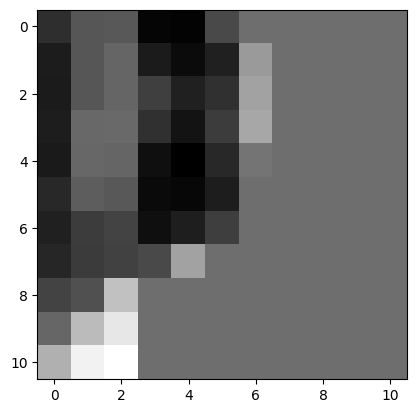

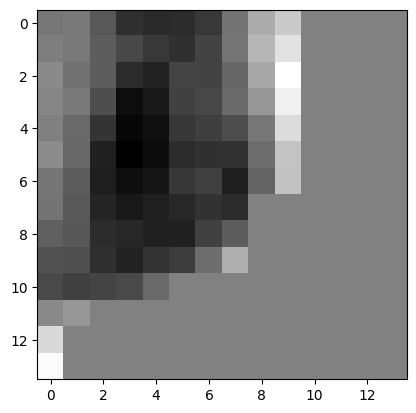

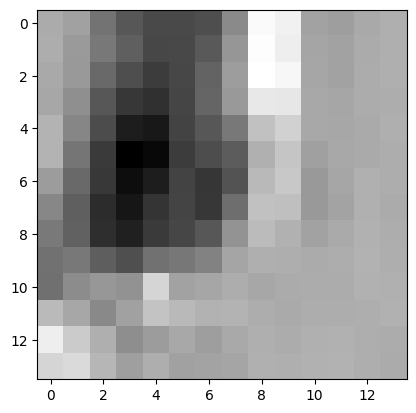

In [18]:

s = 5
i = 50
j = 50
k = 25

shuffle_indices = [(c, b, a)
                   for a in range(2)
                   for b in range(2)
                   for c in range(2)]

upsampling_rate = 2

hr_patch = np.copy(data[2][s][
                        ds*(i - p_size_o) : ds*(i + p_size_o + 1),
                        ds*(j - p_size_o) : ds*(j + p_size_o + 1),
                        ds*(k - p_size_o) : ds*(k + p_size_o + 1), :]) #* \
           # np.copy((data[3][s])[
           #              ds*(i - p_size_o) : ds*(i + p_size_o + 1),
           #              ds*(j - p_size_o) : ds*(j + p_size_o + 1),
           #              ds*(k - p_size_o) : ds*(k + p_size_o + 1), None])

lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 14))

lr_patch_samp[...,:6] = np.copy(data[1][s][::ds,::ds,::ds,:6])[
                            i - p_size_i : i + p_size_i + 1,
                            j - p_size_i : j + p_size_i + 1,
                            k - p_size_i : k + p_size_i + 1,:6]

# lr_mean = np.mean(lr_patch_samp[...,:6])
# lr_std = np.std(lr_patch_samp[...,:6])

# lr_patch_samp[...,:6] = (lr_patch_samp[...,:6] - lr_mean) / lr_std

# lr_patch_samp[...,6:]

t1_patch = np.copy(data[4][s])[
                                    ds*(i - p_size_i) : ds*(i + p_size_i + 1),
                                    ds*(j - p_size_i) : ds*(j + p_size_i + 1),
                                    ds*(k - p_size_i) : ds*(k + p_size_i + 1),:]

t1_patch = space_to_depth(t1_patch, ds)

# lr_patch_samp[...,6:] = (lr_patch_samp[...,6:] - np.mean(lr_patch_samp[...,6:])) / np.std(lr_patch_samp[...,6:])

# lr_patch = lr_patch_samp[...,:6]

# lr_patch = lr_patch_samp

# lr_patch[lr_mask == 0] = 0

# for ch in range(6):
#     lr_patch_samp[...,ch] = (lr_patch_samp[...,ch] - np.mean(lr_patch_samp[...,ch])) / np.std(lr_patch_samp[...,ch])
#     hr_patch[...,ch] = (hr_patch[...,ch] - np.mean(hr_patch[...,ch])) / np.std(hr_patch[...,ch])

generated_image = generator([lr_patch_samp[None,...,:6],t1_patch[None,...]], training=False)
# generated_image = generator(lr_patch_samp[None,...,:6], training=False)

# print(tf.keras.losses.MeanSquaredError()(hr_patch, generated_image[0,...]))
# print(tf.reduce_mean(tf.square(hr_patch - generated_image[0,...])))

# real_output = discriminator(hr_patch[None,...], training=False)
# fake_output = discriminator(generated_image, training=False)

nch = 6

channel = 0

plt.imshow(lr_patch_samp[:,:,5,channel], cmap='gray') 
plt.figure()
plt.imshow(hr_patch[:,:,6,channel], cmap='gray') 
plt.figure()
plt.imshow((generated_image[0,...])[:,:,6,channel], cmap='gray')
# fig = plt.figure(figsize=(11,16))

# for c in range(6):
#     for i in range(8):
#         fig.add_subplot(6,8,(i+1)+8*c)
#         plt.imshow(generated_image[0,:,:,4,i+(8*c)], cmap='gray')

In [ ]:
# subjects_lr
# subjects_hr# subjects_masks

s = 6

lowres_input = data[1][s][::ds,::ds,::ds,:]

(xsize, ysize, zsize, comp) = lowres_input.shape

print(xsize * ds, ysize * ds, zsize * ds)

result_image = np.zeros((xsize*ds, ysize*ds, zsize*ds, comp))

# result_image = np.zeros((xsize, ysize, zsize, comp))

recon_indx = [(i, j, k) for k in np.arange(p_size_i+1,
                                           zsize-p_size_i+1,
                                           2*p_size_o+1)
                        for j in np.arange(p_size_i+1,
                                           ysize-p_size_i+1,
                                           2*p_size_o+1)
                        for i in np.arange(p_size_i+1,
                                           xsize-p_size_i+1,
                                           2*p_size_o+1)]

for (i, j, k) in tqdm(recon_indx):

    if (i - p_size_i < 0 or j - p_size_i < 0 or k - p_size_i < 0):
        continue

    if (i + p_size_i >= xsize or j + p_size_i >= ysize or k + p_size_i >= zsize):
        continue

    # print(i - p_size_i, i + p_size_i)
    # print(j - p_size_i, j + p_size_i)
    # print(k - p_size_i, k + p_size_i)

    if np.max(data[3][s][::ds,::ds,::ds][i - p_size_i : i + p_size_i,
                                      j - p_size_i : j + p_size_i,
                                      k - p_size_i : k + p_size_i]) != 1:
        continue

    lr_patch_samp = np.zeros((2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 2 * p_size_i + e_or_o, 70))

    lr_patch =  np.copy(data[1][s][::ds,::ds,::ds,:6]*data[3][s][::ds,::ds,::ds,None])[
                            i - p_size_i : i + p_size_i + 1,
                            j - p_size_i : j + p_size_i + 1,
                            k - p_size_i : k + p_size_i + 1,:]

    t1_patch =  np.copy(data[4][s])[
                        ds*(i - p_size_i - 1) : ds*(i + p_size_i),
                        ds*(j - p_size_i - 1) : ds*(j + p_size_i),
                        ds*(k - p_size_i - 1) : ds*(k + p_size_i),:]

    lr_patch_samp[...,:6] = lr_patch

    lr_patch_samp[...,6:] = space_to_depth(t1_patch, ds)

    # lr_patchvals = np.zeros((6,2))

    # for ch in range(6):
    #     lr_patchvals[ch,:] = np.array([np.mean(lr_patch[...,ch]), np.std(lr_patch[...,ch])])
    #     lr_patch[...,ch] = (lr_patch[...,ch] - lr_patchvals[ch,0]) / lr_patchvals[ch,1]

    # lr_patch = lr_patch_samp
    

    output_patch = generator([lr_patch_samp[None,...,:6], lr_patch_samp[None,...,6:]], training=False)
    # output_patch = generator(lr_patch[None,...], training=False)

    opatch = np.array(output_patch[0,...])

    # for ch in range(6):
    #     opatch[...,ch] = (opatch[...,ch] * lr_patchvals[ch,1]) + lr_patchvals[ch,0] 

    # result_image[2*(i - p_size_o - 1) : 2*(i + p_size_o),
    #              2*(j - p_size_o - 1) : 2*(j + p_size_o),
    #              2*(k - p_size_o - 1) : 2*(k + p_size_o), :] = output_patch[0,...]

    result_image[ds*(i - p_size_o) : ds*(i + p_size_o + 1),
                 ds*(j - p_size_o) : ds*(j + p_size_o + 1),
                 ds*(k - p_size_o) : ds*(k + p_size_o + 1), :] = (opatch)

# result_image[subjects_masks[6] == 0] = 0
    

In [ ]:
result_image[subjects_masks[6] == 0] = 0

In [ ]:
lr_interp = np.zeros(subjects_hr[6].shape)

for ch in range(6):
    lr_interp[...,ch] = zoom((np.copy(subjects_lr[6][...,ch]) * transform_lr[6][ch,1] + transform_lr[6][ch,0])[::ds,::ds,::ds], ds, order=3)

lr_interp[subjects_masks[6] == 0] = 0

In [ ]:
print(tf.reduce_mean(tf.square(subjects_hr[6] - lr_interp)))
print(tf.reduce_mean(tf.square(subjects_hr[6] - result_image)))

In [ ]:
zdim = 80
channel = 3

print(subjects_lr[6][::2,::2,zdim,channel].shape)

x = 80 
y = 75

# lr_out = cv2.resize(subjects_lr[6][::2,::2,zdim,channel]
#             *transform_lr[6][channel,1] + transform_lr[6][channel,0], (104*2, 96*2))

# lr_out = (zoom(subjects_lr[6][::2,::2,::2,channel], 2) *transform_lr[6][channel,1] + transform_lr[6][channel,0])[:,:,zdim]

# lr_out = (subjects_lr[6][:,:,:,channel]*transform_lr[6][channel,1] + transform_lr[6][channel,0])[:,:,zdim]

lr_out = zoom((np.copy(subjects_lr[6][...,channel]) * transform_lr[6][channel,1] + transform_lr[6][channel,0])[::ds,::ds,::ds], ds, order=3)

hr_out = result_image[:,:,zdim,channel]*transform_lr[6][channel,1] + transform_lr[6][channel,0]

hr_act = subjects_hr[6][:,:,zdim,channel]*transform_hr[6][channel,1] + transform_lr[6][channel,0]

# lr_out = cv2.resize(subjects_lr[6][::2,::2,zdim,channel]
#             *transform_lr[6][0] + transform_lr[6][1], (104*2, 96*2))

# hr_out = result_image[:,:,zdim,channel]*transform_lr[6][0] + transform_lr[6][1]

# hr_act = subjects_hr[6][:,:,zdim,channel]*transform_hr[6][0] + transform_hr[6][1]

fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,4,1)
plt.imshow(lr_interp[:,:,zdim, channel], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(hr_out, cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(hr_act, cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(depth_to_space(subjects_t1[6])[:,:,zdim*2-2,0], cmap='gray')

In [ ]:
# plt.imshow(lr_out[50:90,60:120], cmap='gray')
# plt.figure()
# plt.imshow(hr_out[50:90,60:120], cmap='gray')
# plt.figure()
# plt.imshow(hr_act[50:90,60:120], cmap='gray')

# print(np.min(subjects_lr[6][40:80,60:120,zdim,channel]), np.min(subjects_hr[6][40:80,60:120,zdim,channel]), np.min(result_image[40:80,60:120,zdim,channel]))

fig = plt.figure(figsize=(11,16))

fig.add_subplot(1,4,1)
plt.imshow(lr_out[30:130,60:120,zdim], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(hr_out[30:130,60:120], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(hr_act[30:130,60:120], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(depth_to_space(subjects_t1[6])[:,:,zdim*2,0][30*2-2:130*2-2,60*2-2:120*2-2], cmap='gray')

In [ ]:
lr_act = np.pad(subjects_lr[6], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_act = np.pad(subjects_hr[6], ((0,0), (0,0), (0,0), (2,0)), mode='constant')
hr_pred = np.pad(result_image, ((0,0), (0,0), (0,0), (2,0)), mode='constant')

for ch in range(2,8):
    lr_act[...,ch] = zoom(subjects_lr[6][::ds,::ds,::ds,ch-2], ds) * transform_lr[6][ch-2,1] + transform_lr[6][ch-2,0]
    lr_act[subjects_masks[6] == 0] = 0
    hr_act[...,ch] = subjects_hr[6][...,ch-2] * transform_hr[6][ch-2,1] + transform_hr[6][ch-2,0]
    hr_act[subjects_masks[6] == 0] = 0
    hr_pred[...,ch] = result_image[...,ch-2] * transform_lr[6][ch-2,1] + transform_lr[6][ch-2,0]
    hr_pred[subjects_masks[6] == 0] = 0

    # lr_act[...,ch] = zoom(subjects_lr[6][::2,::2,::2,ch-2], 2)
    # lr_act[subjects_masks[6] == 0] = 0
    # hr_act[...,ch] = subjects_hr[6][...,ch-2]
    # hr_act[subjects_masks[6] == 0] = 0
    # hr_pred[...,ch] = result_image[...,ch-2]
    # hr_pred[subjects_masks[6] == 0] = 0

In [ ]:
[XSIZE, YSIZE, ZSIZE, dim] = hr_act.shape


md_lr_i, fa_lr_i, cfa_lr_i = data_utils.calc_MD_FA_CFA(lr_act[::ds,::ds,::ds,:], XSIZE//ds, YSIZE//ds, ZSIZE//ds)
md_lr, fa_lr, cfa_lr = data_utils.calc_MD_FA_CFA(lr_act, XSIZE, YSIZE, ZSIZE)
md_hr, fa_hr, cfa_hr = data_utils.calc_MD_FA_CFA(hr_act, XSIZE, YSIZE, ZSIZE)
md_gen, fa_gen, cfa_gen = data_utils.calc_MD_FA_CFA(hr_pred, XSIZE, YSIZE, ZSIZE)

In [ ]:
zdim = 96

fig = plt.figure(figsize=(20,16))

fig.add_subplot(3,4,1)
plt.imshow(md_lr_i[:,:,zdim//ds], cmap='gray')
fig.add_subplot(3,4,2)
plt.imshow(md_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,3)
plt.imshow(md_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,4)
plt.imshow(md_hr[:,:,zdim], cmap='gray')

fig.add_subplot(3,4,5)
plt.imshow(fa_lr_i[:,:,zdim//ds], cmap='gray')
fig.add_subplot(3,4,6)
plt.imshow(fa_lr[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,7)
plt.imshow(fa_gen[:,:,zdim], cmap='gray')
fig.add_subplot(3,4,8)
plt.imshow(fa_hr[:,:,zdim], cmap='gray')

fig.add_subplot(3,4,9)
plt.imshow(cfa_lr_i[:,:,zdim//ds], cmap='gray')
fig.add_subplot(3,4,10)
plt.imshow(cfa_lr[:,:,zdim], vmax=1)
fig.add_subplot(3,4,11)
plt.imshow(cfa_gen[:,:,zdim], vmax=1)
fig.add_subplot(3,4,12)
plt.imshow(cfa_hr[:,:,zdim], vmax=1)

In [ ]:
fig = plt.figure(figsize=(20,16))

fig.add_subplot(1,4,1)
plt.imshow(md_lr_i[30:55,50:75,zdim//ds], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(md_lr[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(md_gen[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(md_hr[60:110,100:150,zdim], cmap='gray')

In [ ]:
fig = plt.figure(figsize=(20,16))

fig.add_subplot(1,4,1)
plt.imshow(fa_lr_i[30:55,50:75,zdim//ds], cmap='gray')
fig.add_subplot(1,4,2)
plt.imshow(fa_lr[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,3)
plt.imshow(fa_gen[60:110,100:150,zdim], cmap='gray')
fig.add_subplot(1,4,4)
plt.imshow(fa_hr[60:110,100:150,zdim], cmap='gray')

In [ ]:
# cv2.resize(md_lr[::2,::2,zdim], (104*2, 96*2))
# fig.add_subplot(3,3,4)
# plt.imshow(cv2.resize(fa_lr[::2,::2,zdim], (104*2, 96*2)), cmap='gray')
# fig.add_subplot(3,3,5)
# plt.imshow(fa_gen[:,:,zdim], cmap='gray')
# fig.add_subplot(3,3,6)
# plt.imshow(fa_hr[:,:,zdim], cmap='gray')


# print(np.mean(np.square(cv2.resize(md_lr[::2,::2,zdim], (104*2, 96*2)) - md_hr[:,:,zdim])))
# print(np.mean(np.square(md_lr[:,:,:] - md_hr[:,:,:])))
# print(np.mean(np.square(md_gen[:,:,:] - md_hr[:,:,:])))

# print(np.mean(np.square(cv2.resize(fa_lr[::2,::2,zdim], (104*2, 96*2)) - fa_hr[:,:,zdim])))
# print(np.mean(np.square(fa_gen[:,:,zdim] - fa_hr[:,:,zdim])))


print(ssim(md_hr[:,:,:], md_lr[:,:,:], data_range=np.max(md_hr) - np.min(md_hr)))
print(ssim(md_hr[:,:,:], md_gen[:,:,:], data_range=np.max(md_hr) - np.min(md_hr)))

print(ssim(fa_hr[:,:,:], fa_lr[:,:,:], data_range=np.max(fa_hr) - np.min(fa_hr)))
print(ssim(fa_hr[:,:,:], fa_gen[:,:,:], data_range=np.max(fa_hr) - np.min(fa_hr)))
# print(np.mean(np.square(cv2.resize(md_lr[::2,::2,zdim], (104*2, 96*2)) - md_hr[:,:,zdim])))
# print(np.mean(np.square(md_gen[:,:,zdim] - md_hr[:,:,zdim])))


811